In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

Data generation

In [210]:
#Define the number of elements in each set I, J, K
i_num = 25
k_num = 1
j_num = 200 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])


In [211]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 100), 4)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 100), 4)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 100), 4)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 100), 4)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 100), 4)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 100), 4)

J.index = J['Point number'] 
J = pd.concat([J, K, I], axis = 0) #Include K to J
I.index

Index(['i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10',
       'i11', 'i12', 'i13', 'i14', 'i15', 'i16', 'i17', 'i18', 'i19', 'i20',
       'i21', 'i22', 'i23', 'i24'],
      dtype='object', name='Point number')

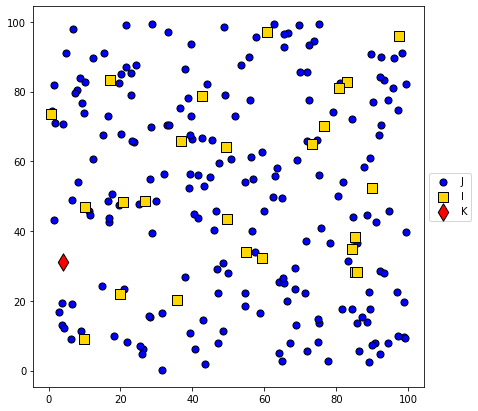

In [212]:
axs, fig = plt.subplots(1, 1, figsize = (7, 7))

fig.scatter(J['Latitude'], J['Longitude'], color = 'blue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Latitude'], K['Longitude'], color = 'red', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [55]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import shapely
#%pip install folium matplotlib mapclassify
import folium
import matplotlib

# Doctor's coordinates
doctors = {'Latitude' : [48.56500199216254, 48.5705, 48.575], 'Longitude' : [13.433214775837387, 13.436, 13.44]}
df = pd.DataFrame(doctors)
df

# create geodataframe, NB CRS
geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]), crs="epsg:4386")


with open('Polygon Passau.txt', 'r') as file:
    # Read the contents of the file into a string
    polygon_str = file.read()

# Now file_contents contains the contents of the file as a string
passau_poly = shapely.wkt.loads(polygon_str)


passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)
folium.GeoJson(passau_gdf).add_to(passau_map)

geo_doctors = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]), crs="epsg:4326")

for idx, row in geo_doctors.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], icon=folium.Icon(icon='circle', prefix='fa', color='blue'), 
                  icon_size=(0.5, 0.5)).add_to(passau_map)

lines = []
for i in range(len(geo_doctors) - 1):
    point1 = geo_doctors.iloc[i].geometry
    point2 = geo_doctors.iloc[i + 1].geometry
    lines.append([point1.coords[0], point2.coords[0]])

folium.PolyLine(lines, color='blue').add_to(passau_map)



passau_map

#m

In [213]:
#Define constants

B = 100
S = 10
alpha = 10

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 400
    else:
        beta[j] = 300
        
q_j = {j: 50 for j in J.index}
up_bound = 12
mu = {i : int(round(random.uniform(0, up_bound), 0)) for i in I.index}

mu

{'i0': 11,
 'i1': 11,
 'i2': 10,
 'i3': 5,
 'i4': 10,
 'i5': 2,
 'i6': 0,
 'i7': 1,
 'i8': 8,
 'i9': 10,
 'i10': 1,
 'i11': 1,
 'i12': 6,
 'i13': 3,
 'i14': 1,
 'i15': 7,
 'i16': 0,
 'i17': 0,
 'i18': 1,
 'i19': 4,
 'i20': 5,
 'i21': 7,
 'i22': 10,
 'i23': 8,
 'i24': 3}

Deterministic model

In [214]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 5,
 'i1': 14,
 'i2': 11,
 'i3': 2,
 'i4': 7,
 'i5': 1,
 'i6': 0,
 'i7': 2,
 'i8': 11,
 'i9': 13,
 'i10': 0,
 'i11': 3,
 'i12': 6,
 'i13': 0,
 'i14': 2,
 'i15': 8,
 'i16': 0,
 'i17': 0,
 'i18': 0,
 'i19': 4,
 'i20': 5,
 'i21': 8,
 'i22': 11,
 'i23': 5,
 'i24': 1}

In [215]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 85.99466330604474,
 ('k0', 'j1'): 89.8268627047611,
 ('k0', 'j2'): 63.26521610569271,
 ('k0', 'j3'): 74.33557988641778,
 ('k0', 'j4'): 18.60344138109936,
 ('k0', 'j5'): 86.39629248648347,
 ('k0', 'j6'): 48.486317080595015,
 ('k0', 'j7'): 74.448788525066,
 ('k0', 'j8'): 71.07218370565238,
 ('k0', 'j9'): 65.27558283592725,
 ('k0', 'j10'): 40.72400689924802,
 ('k0', 'j11'): 25.92775521810556,
 ('k0', 'j12'): 89.82071903130146,
 ('k0', 'j13'): 87.57952999674067,
 ('k0', 'j14'): 43.78252601438158,
 ('k0', 'j15'): 60.30676968052592,
 ('k0', 'j16'): 18.09897645420867,
 ('k0', 'j17'): 94.3925343315879,
 ('k0', 'j18'): 90.6023735941835,
 ('k0', 'j19'): 66.83373440419142,
 ('k0', 'j20'): 91.85778268589982,
 ('k0', 'j21'): 17.104134071036743,
 ('k0', 'j22'): 64.33988442676906,
 ('k0', 'j23'): 79.17505449906555,
 ('k0', 'j24'): 44.92000494312084,
 ('k0', 'j25'): 72.21586230988314,
 ('k0', 'j26'): 46.00592496766042,
 ('k0', 'j27'): 31.00885082053187,
 ('k0', 'j28'): 57.74419812327468

In [216]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j4'),
 ('k0', 'j6'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j14'),
 ('k0', 'j16'),
 ('k0', 'j21'),
 ('k0', 'j24'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j31'),
 ('k0', 'j33'),
 ('k0', 'j38'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j46'),
 ('k0', 'j49'),
 ('k0', 'j51'),
 ('k0', 'j53'),
 ('k0', 'j55'),
 ('k0', 'j57'),
 ('k0', 'j63'),
 ('k0', 'j65'),
 ('k0', 'j67'),
 ('k0', 'j72'),
 ('k0', 'j74'),
 ('k0', 'j75'),
 ('k0', 'j76'),
 ('k0', 'j77'),
 ('k0', 'j78'),
 ('k0', 'j79'),
 ('k0', 'j80'),
 ('k0', 'j82'),
 ('k0', 'j86'),
 ('k0', 'j96'),
 ('k0', 'j97'),
 ('k0', 'j98'),
 ('k0', 'j101'),
 ('k0', 'j102'),
 ('k0', 'j104'),
 ('k0', 'j107'),
 ('k0', 'j108'),
 ('k0', 'j113'),
 ('k0', 'j119'),
 ('k0', 'j120'),
 ('k0', 'j121'),
 ('k0', 'j124'),
 ('k0', 'j125'),
 ('k0', 'j126'),
 ('k0', 'j134'),
 ('k0', 'j139'),
 ('k0', 'j142'),
 ('k0', 'j152'),
 ('k0', 'j153'),
 ('k0', 'j154'),
 ('k0', 'j163'),
 ('k0', 'j169'),
 ('k0', 'j170'),
 ('k0', 'j171'),
 ('k0', 'j172'),
 ('k0', 'j174'),
 (

In [217]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas


[('k0', 'j4'),
 ('k0', 'j11'),
 ('k0', 'j16'),
 ('k0', 'j21'),
 ('k0', 'j24'),
 ('k0', 'j27'),
 ('k0', 'j33'),
 ('k0', 'j38'),
 ('k0', 'j46'),
 ('k0', 'j51'),
 ('k0', 'j65'),
 ('k0', 'j76'),
 ('k0', 'j77'),
 ('k0', 'j79'),
 ('k0', 'j80'),
 ('k0', 'j82'),
 ('k0', 'j86'),
 ('k0', 'j98'),
 ('k0', 'j101'),
 ('k0', 'j104'),
 ('k0', 'j108'),
 ('k0', 'j120'),
 ('k0', 'j121'),
 ('k0', 'j124'),
 ('k0', 'j126'),
 ('k0', 'j134'),
 ('k0', 'j139'),
 ('k0', 'j142'),
 ('k0', 'j152'),
 ('k0', 'j153'),
 ('k0', 'j163'),
 ('k0', 'j178'),
 ('k0', 'j181'),
 ('k0', 'j190'),
 ('k0', 'j192'),
 ('k0', 'j194'),
 ('k0', 'i2'),
 ('k0', 'i6'),
 ('k0', 'i8'),
 ('k0', 'i15'),
 ('k0', 'i17'),
 ('k0', 'i18'),
 ('k0', 'i19'),
 ('k0', 'i22'),
 ('k0', 'i24')]

In [218]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [219]:
model_det = gp.Model('Deterministic model')

x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [220]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c6')

{('k0', 'i24', 'i24'): <gurobi.Constr *Awaiting Model Update*>}

In [221]:
model_det.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_det.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 56 rows, 2201 columns and 164 nonzeros
Model fingerprint: 0xbcd90941
Variable types: 0 continuous, 2201 integer (226 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 2760.0000000
Presolve removed 36 rows and 2163 columns
Presolve time: 0.00s
Presolved: 20 rows, 38 columns, 58 nonzeros
Found heuristic solution: objective 2460.0000000
Variable types: 0 continuous, 38 integer (18 binary)

Root relaxation: objective 2.060000e+03, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incu

In [222]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, v.X))
                                #print(v)
                print("\n")
                
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 3
0
2060 
x_ikj[i2,k0,j104] 11
x_ikj[i8,k0,i8] 11
x_ikj[i15,k0,i15] 8
x_ikj[i19,k0,i19] 4
x_ikj[i22,k0,j104] 11
x_ikj[i24,k0,i24] 1
y_j[j104] 1
y_j[i8] 1
y_j[i15] 1
y_j[i19] 1
y_j[i24] 1


1
2460 
x_ikj[i2,k0,j104] 11
x_ikj[i8,k0,i8] 11
x_ikj[i15,k0,i15] 8
x_ikj[i19,k0,i19] 4
x_ikj[i22,k0,j104] 11
x_ikj[i24,k0,i24] 1
y_j[j104] 1
y_j[i8] 1
y_j[i15] 1
y_j[i19] 1
y_j[i24] 1


2
2760 
x_ikj[i2,k0,j104] 11
x_ikj[i8,k0,i8] 11
x_ikj[i15,k0,i15] 8
x_ikj[i19,k0,i19] 4
x_ikj[i22,k0,j104] 11
x_ikj[i24,k0,i24] 1
y_j[j104] 1
y_j[i8] 1
y_j[i15] 1
y_j[i19] 1
y_j[i24] 1






In [223]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    return results_doctors, results_locations

SolutionSummary(model_det)

(     i  Number of drones
 0  i15                 8
 1  i19                 4
 2   i2                11
 3  i22                11
 4  i24                 1
 5   i8                11,
       j  Number of drones
 0   i15                 8
 1   i19                 4
 2   i24                 1
 3    i8                11
 4  j104                22)

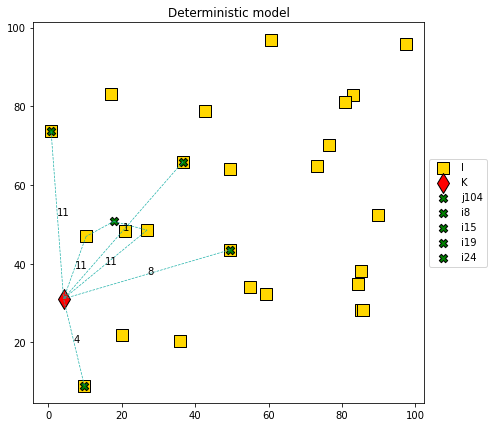

In [224]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (7, 7))
                
        fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 150, label = 'I')
        fig.scatter(K['Latitude'], K['Longitude'], color = 'red', edgecolors = 'black',
                                marker = 'd', s = 200, label = 'K')
        
        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        (J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.plot((I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                        (I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                (K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                                #fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                #(J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Latitude'], J.loc[index_y, 'Longitude'], color = 'green',
                                        edgecolors = 'black', s = 70, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)

In [225]:
for v in model_det.getVars():
        if v.xn > 0:
            if v.varName.startswith('x_ikj'):
                indices_x = v.varName[6:-1].split(',')
indices_x

['i24', 'k0', 'i24']

Probabilistic model

In [259]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

p = 0.98

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))


bound = 0.9999999999999999
g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = int(theta_ran_i[i].ppf(bound))

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in IG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))

In [227]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [228]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i2', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 18): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 19): <gurobi.Constr *Awaiting

In [229]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')
model_prob.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c19')

{('k0', 'i24', 'i24'): <gurobi.Constr *Awaiting Model Update*>}

In [230]:
model_prob.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_prob.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 288 rows, 2920 columns and 174297 nonzeros
Model fingerprint: 0x7416e46d
Variable types: 0 continuous, 2920 integer (945 binary)


Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+00, 1e+02]
Found heuristic solution: objective 5000.0000000
Presolve removed 241 rows and 2835 columns
Presolve time: 0.09s
Presolved: 47 rows, 85 columns, 133 nonzeros
Variable types: 0 continuous, 85 integer (41 binary)

Root relaxation: objective 4.006390e+03, 50 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 4006.39024    0    6 5000.00000 4006.39024  19.9%     -    0s
H    0     0                    4500.0000000 4006.39024  11.0%     -    0s
     0     0 4500.00000    0    5 4500.00000 4500.00000  0.00%     -    0s

Cutting planes:
  Flow cover: 12

Explored 1 nodes (60 simplex iterations) in 0.14 seconds (0.03 work units)
Thread count was 8 (of 8 available processors)

Soluti

In [231]:
ListSolution(model_prob)

Number of solutions found: 2
0
4500 
x_ikj[i2,k0,i2] 45
x_ikj[i8,k0,i8] 40
x_ikj[i15,k0,i15] 38
x_ikj[i18,k0,i18] 17
x_ikj[i19,k0,i19] 29
x_ikj[i22,k0,i17] 45
x_ikj[i24,k0,i24] 26
y_j[i2] 1
y_j[i8] 1
y_j[i15] 1
y_j[i17] 1
y_j[i18] 1
y_j[i19] 1
y_j[i24] 1


1
5000 
x_ikj[i2,k0,i2] 45
x_ikj[i8,k0,i8] 40
x_ikj[i15,k0,i15] 38
x_ikj[i18,k0,i18] 17
x_ikj[i19,k0,i19] 29
x_ikj[i22,k0,i17] 45
x_ikj[i24,k0,i24] 26
y_j[i2] 1
y_j[i8] 1
y_j[i15] 1
y_j[i17] 1
y_j[i18] 1
y_j[i19] 1
y_j[i24] 1






In [232]:
SolutionSummary(model_prob)

(     i  Number of drones
 0  i15                38
 1  i18                17
 2  i19                29
 3   i2                45
 4  i22                45
 5  i24                26
 6   i8                40,
      j  Number of drones
 0  i15                38
 1  i17                45
 2  i18                17
 3  i19                29
 4   i2                45
 5  i24                26
 6   i8                40)

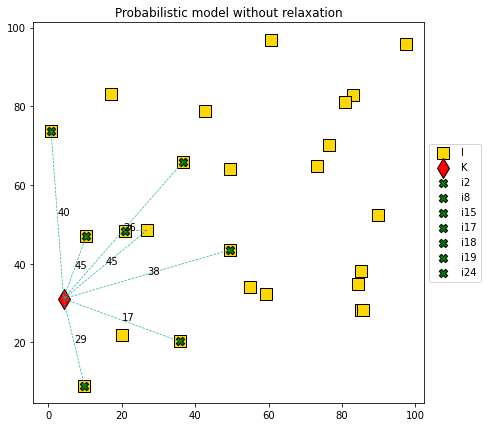

In [233]:
SolutionGraph(I, K, J, model_prob)

Probabilistic model with relaxed constraints

In [234]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 (

In [235]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas

[('k0', 'j4'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j29'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 ('k0', 'j68'),
 ('k0', 'j69'),
 ('k0', 'j72'),
 ('k0', 'j76'),
 ('k0', 'j77'),
 ('k0', 'j79'),
 ('k0', 'j80'),
 ('k0', 'j81'),
 ('k0', 'j82'),
 ('k0', 'j84'),
 ('k0', 'j86'),
 ('k0', 'j87'),
 ('k0', 'j90'),
 ('k0', 'j94'),
 ('k0', 'j95'),
 ('k0', 'j96'),
 ('k0', 'j98'),
 ('k0', 'j101'),
 ('k0', 'j102'),
 ('k0', 'j103'),
 ('k0', 'j104'),
 ('k0', 'j105'),
 ('k0', 'j106'),
 ('k0', 'j108'),
 ('k0', 'j109'),
 ('k0', 'j111'),
 (

In [236]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [237]:
#Redefine constants and random variables


I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))

In [238]:
model_prob_rel = gp.Model('Probabilistic model with relaxation')

x_ikj = model_prob_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob_rel.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [239]:
model_prob_rel.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')
model_prob_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')
model_prob_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c19')


model_prob_rel.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_prob_rel.optimize()

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 856 rows, 6320 columns and 504464 nonzeros
Model fingerprint: 0x645728d0
Variable types: 0 continuous, 6320 integer (945 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+00, 1e+02]
Found heuristic solution: objective 14630.000000
Presolve removed 724 rows and 6050 columns
Presolve time: 0.31s
Presolved: 132 rows, 270 columns, 446 nonzeros
Variable types: 0 continuous, 270 integer (112 binary)

Root relaxation: objective 1.129917e+04, 177 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work


In [240]:
ListSolution(model_prob_rel)

Number of solutions found: 4
0
13030 
x_ikj[i0,k0,i0] 13
x_ikj[i0,k0,i20] 30
x_ikj[i0,k0,i21] 5
x_ikj[i1,k0,i1] 48
x_ikj[i2,k0,i2] 45
x_ikj[i3,k0,i5] 32
x_ikj[i4,k0,i4] 12
x_ikj[i4,k0,i20] 15
x_ikj[i4,k0,i21] 18
x_ikj[i5,k0,j182] 22
x_ikj[i7,k0,i7] 17
x_ikj[i8,k0,i8] 40
x_ikj[i9,k0,i9] 45
x_ikj[i10,k0,i10] 17
x_ikj[i11,k0,i1] 2
x_ikj[i11,k0,i11] 15
x_ikj[i12,k0,i14] 35
x_ikj[i14,k0,j182] 2
x_ikj[i14,k0,i14] 15
x_ikj[i15,k0,i15] 38
x_ikj[i18,k0,i18] 17


x_ikj[i19,k0,i19] 29
x_ikj[i20,k0,i0] 19
x_ikj[i20,k0,i21] 13
x_ikj[i21,k0,i0] 18
x_ikj[i21,k0,i4] 20
x_ikj[i22,k0,i22] 45
x_ikj[i23,k0,i23] 40
x_ikj[i24,k0,i24] 26
y_j[j182] 1
y_j[i0] 1
y_j[i1] 1
y_j[i2] 1
y_j[i4] 1
y_j[i5] 1
y_j[i7] 1
y_j[i8] 1
y_j[i9] 1
y_j[i10] 1
y_j[i11] 1
y_j[i14] 1
y_j[i15] 1
y_j[i18] 1
y_j[i19] 1
y_j[i20] 1
y_j[i21] 1
y_j[i22] 1
y_j[i23] 1
y_j[i24] 1


1
13130 
x_ikj[i0,k0,i0] 13
x_ikj[i0,k0,i20] 30
x_ikj[i0,k0,i21] 5
x_ikj[i1,k0,i1] 48
x_ikj[i2,k0,i2] 45
x_ikj[i3,k0,i5] 32
x_ikj[i4,k0,i4] 12
x_ikj[i4,k0,i20] 15
x_ikj[i4,k0,i21] 18
x_ikj[i5,k0,j182] 22
x_ikj[i7,k0,i7] 17
x_ikj[i8,k0,i8] 40
x_ikj[i9,k0,i9] 45
x_ikj[i10,k0,i10] 17
x_ikj[i11,k0,i1] 2
x_ikj[i11,k0,i11] 15
x_ikj[i12,k0,i14] 35
x_ikj[i14,k0,j182] 2
x_ikj[i14,k0,i14] 15
x_ikj[i15,k0,i15] 38
x_ikj[i18,k0,i18] 17
x_ikj[i19,k0,i19] 29
x_ikj[i20,k0,i0] 19
x_ikj[i20,k0,i21] 13
x_ikj[i21,k0,i0] 18
x_ikj[i21,k0,i4] 20
x_ikj[i22,k0,i22] 45
x_ikj[i23,k0,i23] 40
x_ikj[i24,k0,i24] 26
y_j[j182] 1
y_j[i0] 1
y_j[i

In [241]:
SolutionSummary(model_prob_rel)

(      i  Number of drones
 0    i0                48
 1    i1                48
 2   i10                17
 3   i11                17
 4   i12                35
 5   i14                17
 6   i15                38
 7   i18                17
 8   i19                29
 9    i2                45
 10  i20                32
 11  i21                38
 12  i22                45
 13  i23                40
 14  i24                26
 15   i3                32
 16   i4                45
 17   i5                22
 18   i7                17
 19   i8                40
 20   i9                45,
        j  Number of drones
 0     i0                50
 1     i1                50
 2    i10                17
 3    i11                15
 4    i14                50
 5    i15                38
 6    i18                17
 7    i19                29
 8     i2                45
 9    i20                45
 10   i21                36
 11   i22                45
 12   i23                40
 13   i24    

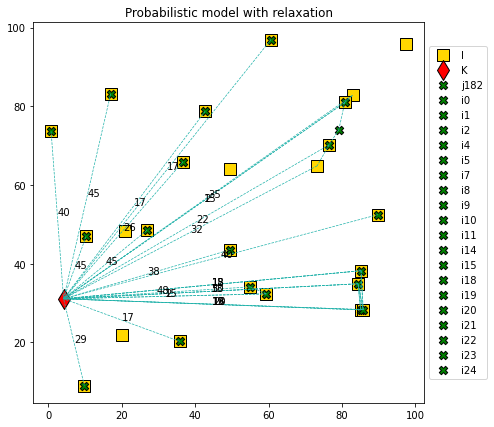

In [242]:
SolutionGraph(I, K, J, model_prob_rel)

Deterministic model with relaxed constraints

In [243]:
model_det_rel = gp.Model('Deterministic model with relaxation')

x_ikj = model_det_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [244]:
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c4')
model_det_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c5')
model_det_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c6')

model_det_rel.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_det_rel.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 186 rows, 5601 columns and 549 nonzeros
Model fingerprint: 0x6321ea17
Variable types: 0 continuous, 5601 integer (226 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 7590.0000000
Presolve removed 160 rows and 5530 columns
Presolve time: 0.02s
Presolved: 26 rows, 71 columns, 121 nonzeros
Found heuristic solution: objective 5490.0000000
Variable types: 0 continuous, 71 integer (21 binary)

Root relaxation: objective 4.307647e+03, 49 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | I

In [245]:
ListSolution(model_det_rel)

Number of solutions found: 6
0
4490 
x_ikj[i0,k0,i4] 5
x_ikj[i1,k0,j199] 14
x_ikj[i2,k0,j79] 11
x_ikj[i3,k0,i3] 2
x_ikj[i4,k0,i4] 7
x_ikj[i5,k0,i3] 1
x_ikj[i7,k0,i7] 2
x_ikj[i8,k0,j113] 11
x_ikj[i9,k0,j113] 13
x_ikj[i11,k0,j199] 3
x_ikj[i12,k0,i14] 6
x_ikj[i14,k0,i14] 2
x_ikj[i15,k0,j199] 8
x_ikj[i19,k0,i19] 4
x_ikj[i20,k0,i4] 5
x_ikj[i21,k0,i4] 8
x_ikj[i22,k0,j79] 11
x_ikj[i23,k0,i23] 5
x_ikj[i24,k0,i24] 1
y_j[j79] 1
y_j[j113] 1
y_j[j199] 1
y_j[i3] 1
y_j[i4] 1
y_j[i7] 1
y_j[i14] 1
y_j[i19] 1
y_j[i23] 1
y_j[i24] 1


1
4590 
x_ikj[i0,k0,i4] 5
x_ikj[i1,k0,j199] 14
x_ikj[i2,k0,j79] 11
x_ikj[i3,k0,i3] 2
x_ikj[i4,k0,i4] 7
x_ikj[i5,k0,i3] 1
x_ikj[i7,k0,i7] 2
x_ikj[i8,k0,j113] 11
x_ikj[i9,k0,j113] 13
x_ikj[i11,k0,j199] 3
x_ikj[i12,k0,i14] 6
x_ikj[i14,k0,i14] 2
x_ikj[i15,k0,j199] 8
x_ikj[i19,k0,i19] 4
x_ikj[i20,k0,i4] 5
x_ikj[i21,k0,i4] 8
x_ikj[i22,k0,j79] 11
x_ikj[i23,k0,i23] 5
x_ikj[i24,k0,i24] 1
y_j[j79] 1
y_j[j113] 1
y_j[j199] 1
y_j[i3] 1
y_j[i4] 1
y_j[i7] 1
y_j[i14] 1
y_j[i19] 1
y_j[i23] 

In [246]:
SolutionSummary(model_det_rel)

(      i  Number of drones
 0    i0                 5
 1    i1                14
 2   i11                 3
 3   i12                 6
 4   i14                 2
 5   i15                 8
 6   i19                 4
 7    i2                11
 8   i20                 5
 9   i21                 8
 10  i22                11
 11  i23                 5
 12  i24                 1
 13   i3                 2
 14   i4                 7
 15   i5                 1
 16   i7                 2
 17   i8                11
 18   i9                13,
       j  Number of drones
 0   i14                 8
 1   i19                 4
 2   i23                 5
 3   i24                 1
 4    i3                 3
 5    i4                25
 6    i7                 2
 7  j113                24
 8  j199                25
 9   j79                22)

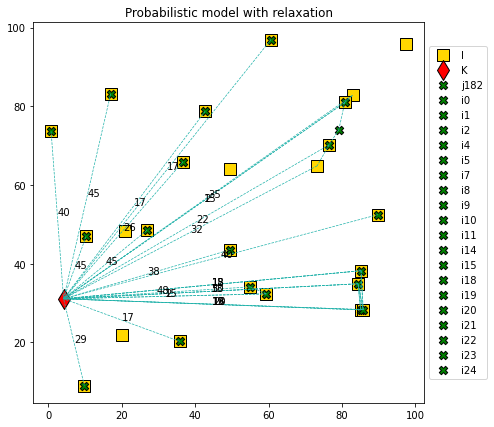

In [247]:
SolutionGraph(I, K, J, model_prob_rel)

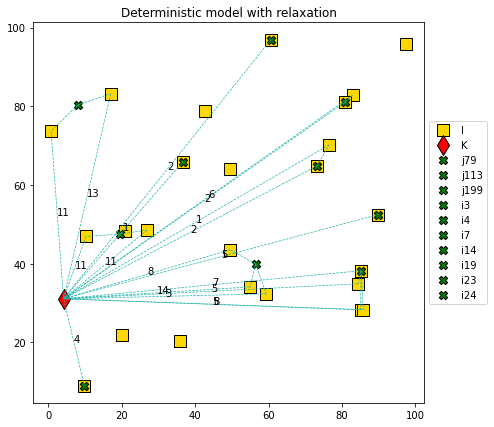

In [248]:
SolutionGraph(I, K, J, model_det_rel)

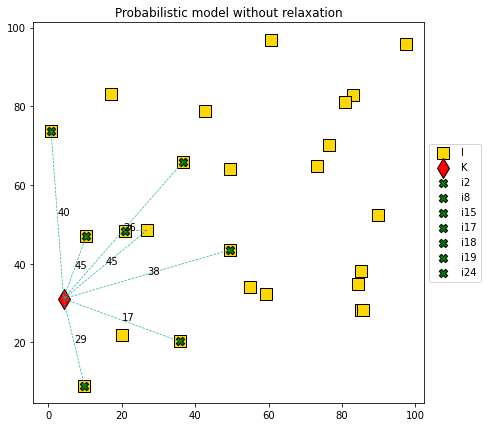

In [249]:
SolutionGraph(I, K, J, model_prob)

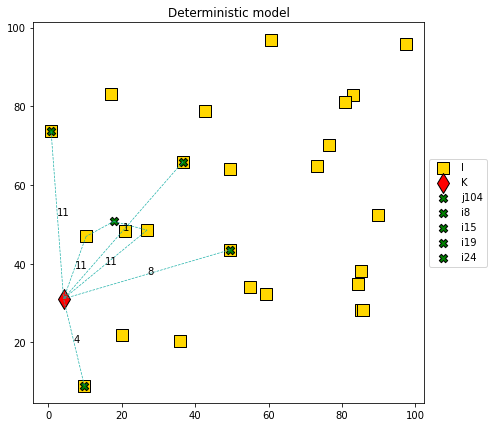

In [250]:
SolutionGraph(I, K, J, model_det)

1) complete information optimum - lower bound for optimum
2) price of uncertainty